In [1]:
import warnings
warnings.filterwarnings('ignore')
from model import cnn_model
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import collections as cll
import itertools
import glob
import os
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, BatchNormalization, AveragePooling2D, LSTM
from keras.optimizers import SGD
from keras.optimizers import Adam, Nadam, Adadelta
from keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
from keras.datasets import mnist
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences
from keras_lr_finder import LRFinder

class My_generator(Sequence):
    def __init__(self, x_set_dir, y_set, batch_size):
        self.x, self.y = x_set_dir, y_set
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # read your data here using the batch lists, batch_x and batch_y
        x = [np.load(filename) for filename in batch_x]
        y = [np.load(filename) for filename in batch_y]
    
        return np.array(x).reshape(self.batch_size,img_rows,img_cols,1), np.array(y) 

Using TensorFlow backend.


In [2]:
def cnn_model_big(input_dim, n_classes, init,drop):
    model = Sequential()
    model.add(Conv2D(128, (4, 4), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu', input_shape=input_dim))
    model.add(Conv2D(128, (4, 4), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(9,1)))
    model.add(Dropout(drop))
    
    model.add(Conv2D(256, (3,3), strides=(1, 1), kernel_initializer=init , activation='relu'))
    model.add(Conv2D(256, (3,3), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(7,1)))
    model.add(Dropout(drop))
    
    model.add(Conv2D(512, (3,3), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(5,1)))
    model.add(Dropout(drop))
    
    model.add(Conv2D(768, (3,3), strides=(1, 1), kernel_initializer=init,activation='relu'))
    model.add(Conv2D(768, (3,3), strides=(1, 1), kernel_initializer=init, padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,1)))
    model.add(Dropout(drop))
    
    model.add(Flatten())
    model.add(Dense(4096, kernel_initializer=init , activation='relu'))
    model.add(Dropout(drop*6))

    model.add(Dense(768, kernel_initializer=init , activation='relu'))
    model.add(Dropout(drop*2))

    return model

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe correta')
    plt.xlabel('Classe prevista')
    
    return fig

In [4]:
img_rows, img_cols = 6410, 8
n_classes = 2
input_shape = (img_rows,img_cols,1)

# B1

In [5]:
train_path = glob.glob(os.path.join('dados/train/', '*.npy'))
test_path = glob.glob(os.path.join('dados/test', '*.npy'))
y_train_dir = glob.glob(os.path.join('dados/B1_y_train/', '*.npy'))
y_test_dir = glob.glob(os.path.join('dados/B1_y_test/', '*.npy'))

In [7]:
batch_size_train = 1
batch_size_test = 1
my_training_batch_generator = My_generator(train_path, y_train_dir, batch_size_train)
my_validation_batch_generator = My_generator(test_path, y_test_dir, batch_size_test)

In [8]:
init = keras.initializers.he_uniform(42)
init2 = keras.initializers.constant(0.001)
model = cnn_model_big(input_shape,n_classes,init,drop=0.1)
model.add(Dense(n_classes,activation='softmax'))
model.load_weights('PesosB1/cruzinho-CNN.ESSE.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6410, 8, 128)      2176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6410, 8, 128)      262272    
_________________________________________________________________
average_pooling2d_1 (Average (None, 712, 8, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 712, 8, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 710, 6, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 710, 6, 256)       590080    
_________________________________________________________________
average_pooling2d_2 (Average (None, 101, 6, 256)       0         
__________

In [9]:
sgd = SGD(lr=0.1, decay=0, momentum=0.9, nesterov=True)
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
nadam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.000001)
adadelta = Adadelta(lr = 1)
filepath = 'PesosB1/cruzinho-CNN-vgg.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'
cb = keras.callbacks.ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model.compile(optimizer = nadam, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
history = model.fit_generator(generator=my_training_batch_generator,
                                          epochs=50,
                                          verbose=1,
                                          use_multiprocessing=True,
                                          workers = 8,
                                          max_queue_size=84, 
                                          validation_data=my_validation_batch_generator, 
                                          validation_steps=(len(test_path) // batch_size_test),
                                          steps_per_epoch=(len(train_path) // batch_size_train),
                                          callbacks = [cb],
                                          initial_epoch=0)

Epoch 1/50
8169/8169 [==============================] - 2768s 339ms/step - loss: 2.3682 - acc: 0.5435 - val_loss: 4.0512 - val_acc: 0.5595
Epoch 2/50
8169/8169 [==============================] - 2749s 337ms/step - loss: 1.7390 - acc: 0.5782 - val_loss: 2.1849 - val_acc: 0.6040
Epoch 3/50
8169/8169 [==============================] - 2764s 338ms/step - loss: 1.6840 - acc: 0.6014 - val_loss: 1.3168 - val_acc: 0.6329
Epoch 4/50
8169/8169 [==============================] - 2741s 336ms/step - loss: 1.6218 - acc: 0.6140 - val_loss: 1.6143 - val_acc: 0.6138
Epoch 5/50
8169/8169 [==============================] - 2772s 339ms/step - loss: 1.4963 - acc: 0.6188 - val_loss: 1.8346 - val_acc: 0.6177
Epoch 6/50
8169/8169 [==============================] - 2778s 340ms/step - loss: 1.4752 - acc: 0.6325 - val_loss: 3.6125 - val_acc: 0.6153
Epoch 7/50
8169/8169 [==============================] - 2802s 343ms/step - loss: 1.3913 - acc: 0.6402 - val_loss: 1.8794 - val_acc: 0.6383
Epoch 8/50
8169/8169 [=====

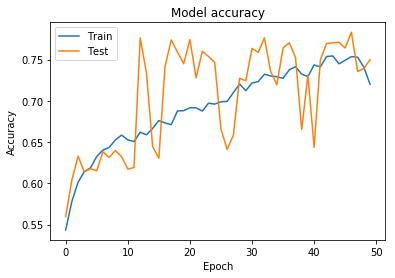

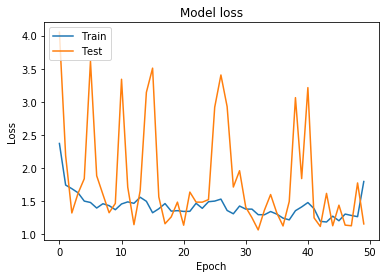

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
y_test = []
y_train = []

for i in y_test_dir:
    tmp = np.load(i)
    y_test.append(tmp)

for i in y_train_dir:
    tmp = np.load(i)
    y_train.append(tmp)

2043/2043 [==============================] - 74s 36ms/step
              precision    recall  f1-score   support

           0     0.9274    0.8300    0.8760      1047
           1     0.8391    0.9317    0.8830       996

   micro avg     0.8796    0.8796    0.8796      2043
   macro avg     0.8832    0.8809    0.8795      2043
weighted avg     0.8843    0.8796    0.8794      2043



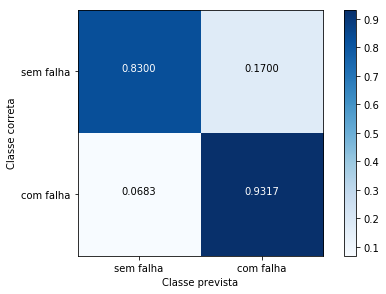

In [16]:
#Predict Test
classes = ['sem falha', 'com falha']
y_testing = np.argmax(y_test, axis =1)
pred = model.predict_generator(my_validation_batch_generator, workers=8, use_multiprocessing=True, verbose=1,max_queue_size=64, steps=(len(test_path) // batch_size_test))
pred = np.argmax(pred, axis = 1)
print(classification_report(y_testing,pred,digits=4))
cm = confusion_matrix(y_testing,pred)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')
cm_plot.savefig('cruzin_b1_test.png',dpi = 'figure', bbox_inches='tight')

8169/8169 [==============================] - 293s 36ms/step
              precision    recall  f1-score   support

           0     0.9610    0.8369    0.8947      4059
           1     0.8571    0.9664    0.9085      4110

   micro avg     0.9021    0.9021    0.9021      8169
   macro avg     0.9091    0.9017    0.9016      8169
weighted avg     0.9087    0.9021    0.9016      8169



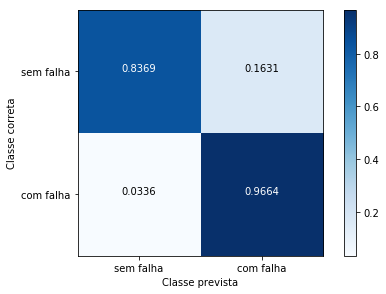

In [17]:
#Predict Train
y_training = np.argmax(y_train, axis = 1)
pred = model.predict_generator(my_training_batch_generator, workers=8, use_multiprocessing=True, verbose=1,max_queue_size=64, steps=(len(train_path) // batch_size_train))
pred = np.argmax(pred, axis = 1)
print(classification_report(y_training,pred,digits=4))
cm = confusion_matrix(y_training,pred)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')
cm_plot.savefig('cruzin_b1_train.png',dpi = 'figure', bbox_inches='tight')